In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [77]:
import warnings
warnings.filterwarnings('ignore')

In [78]:
#Tải bộ dữ liệu
path =r"D:\Nam3\HK2\DoAn2\DS-Customer Segmentation\Customer-Segmentation\OnlineRetail.csv"
df = pd.read_csv(path, encoding ='ISO-8859-1', parse_dates=['InvoiceDate'])

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [80]:
print(f"Initial shape: {df.shape}")

Initial shape: (541909, 8)


In [81]:
# Kiểm tra giá trị bị thiếu
missing_values = df.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [82]:
# Tổng số CustomerID bị thiếu
missing_customerid = df['CustomerID'].isnull().sum()
print(f"Number of missing CustomerIDs: {missing_customerid}")

# Xóa các hàng bị thiếu giá trị CustomerID
df = df.dropna(subset=['CustomerID'])
print(f"Dataset shape after removing missing CustomerIDs: {df.shape}")

Number of missing CustomerIDs: 135080
Dataset shape after removing missing CustomerIDs: (406829, 8)


In [83]:
# Số lượng giao dịch có giá trị âm 
negative_quantity = df[df['Quantity'] < 0].shape[0]
print(f"Number of transactions with negative Quantity: {negative_quantity}")

# Loại bỏ giá trị âm (đơn hủy)
df = df[df['Quantity'] >= 0]
print(f"Dataset shape after removing negative quantities: {df.shape}")

Number of transactions with negative Quantity: 8905
Dataset shape after removing negative quantities: (397924, 8)


In [84]:
# Định dạng lại cột InvoiceDate giá trị ngày/giờ 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Chuyển đổi giá trị CustomerID thành số nguyên 
df['CustomerID'] = df['CustomerID'].astype(int)

In [85]:
#Tính tông giá trị đơn hàng (chi tiêu) = số lương * giá sản phẩm
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

print(f'Cleaned shape: {df.shape}')

Cleaned shape: (397924, 9)


In [86]:
# Ngày tham chiếu: 1 ngày sau ngày lập hoá đơn cuối cùng
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Ngày tham chiếu cho lần mua gần nhất : {reference_date.date()}")

# RFM calculation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalSpend': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print(rfm.head())

Ngày tham chiếu cho lần mua gần nhất : 2011-12-10
   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40


In [87]:
# Tính các mốc phần trăm 20%, 40%, 60%, 80%
rfm_quantiles = {
    'Recency': rfm['Recency'].quantile([0.2, 0.4, 0.6, 0.8]).tolist(),
    'Frequency': rfm['Frequency'].quantile([0.2, 0.4, 0.6, 0.8]).tolist(),
    'Monetary': rfm['Monetary'].quantile([0.2, 0.4, 0.6, 0.8]).tolist()
}

# In kết quả
print(rfm_quantiles)

{'Recency': [13.600000000000023, 33.0, 72.0, 179.0], 'Frequency': [1.0, 2.0, 3.0, 6.0], 'Monetary': [250.106, 489.72400000000005, 941.9419999999996, 2057.914]}


In [88]:

# Tính các giá trị phân vị (quantiles) cho R, F, M
rfm_quantiles = rfm.quantile([0.2, 0.4, 0.6, 0.8])

# Hàm gán điểm Recency (nhỏ hơn là tốt hơn)
def assign_r_score(value):
    if value <= rfm_quantiles['Recency'][0.2]:
        return 5
    elif value <= rfm_quantiles['Recency'][0.4]:
        return 4
    elif value <= rfm_quantiles['Recency'][0.6]:
        return 3
    elif value <= rfm_quantiles['Recency'][0.8]:
        return 2
    else:
        return 1

# Hàm gán điểm Frequency & Monetary (lớn hơn là tốt hơn)
def assign_fm_score(value, column):
    if value <= rfm_quantiles[column][0.2]:
        return 1
    elif value <= rfm_quantiles[column][0.4]:
        return 2
    elif value <= rfm_quantiles[column][0.6]:
        return 3
    elif value <= rfm_quantiles[column][0.8]:
        return 4
    else:
        return 5

# Áp dụng gán điểm cho từng khách hàng
rfm['R'] = rfm['Recency'].apply(assign_r_score)
rfm['F'] = rfm['Frequency'].apply(lambda x: assign_fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: assign_fm_score(x, 'Monetary'))

# Tạo cột RFM_Concat
rfm['RFM_Concat'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# Hàm phân nhóm khách hàng theo R & F
def assign_segment(r, f):
    if (r >= 4 and f >= 4):
        return "Champions"
    elif (r >= 3 and f >= 4):
        return "Loyal Customers"
    elif (r >= 4 and f >= 2):
        return "Potential Loyalist"
    elif (r == 5 and f == 1):
        return "New Customers"
    elif (r == 4 and f == 1):
        return "Promising"
    elif (r == 3 and f == 3):
        return "Needing Attention"
    elif (r == 3 and f <= 2):
        return "About to Sleep"
    elif (r <= 2 and f >= 3):
        return "At Risk"
    elif (r <= 2 and f == 5):
        return "Can't Lose Them"
    elif (r <= 2 and f <= 2):
        return "Hibernating"
    else:
        return "Other"

# Gán nhãn phân nhóm
rfm['Segment'] = rfm.apply(lambda row: assign_segment(row['R'], row['F']), axis=1)

# Hiển thị kết quả
print(rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R', 'F', 'M', 'RFM_Concat', 'Segment']])

      CustomerID  Recency  Frequency  Monetary  R  F  M RFM_Concat  \
0          12346      326          1  77183.60  1  1  5        115   
1          12347        2          7   4310.00  5  5  5        555   
2          12348       75          4   1797.24  2  4  4        244   
3          12349       19          1   1757.55  4  1  4        414   
4          12350      310          1    334.40  1  1  2        112   
...          ...      ...        ...       ... .. .. ..        ...   
4334       18280      278          1    180.60  1  1  1        111   
4335       18281      181          1     80.82  1  1  1        111   
4336       18282        8          2    178.05  5  2  1        521   
4337       18283        4         16   2094.88  5  5  5        555   
4338       18287       43          3   1837.28  3  3  4        334   

                 Segment  
0            Hibernating  
1              Champions  
2                At Risk  
3              Promising  
4            Hibernating

In [89]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Concat,Segment
0,12346,326,1,77183.60,1,1,5,115,Hibernating
1,12347,2,7,4310.00,5,5,5,555,Champions
2,12348,75,4,1797.24,2,4,4,244,At Risk
3,12349,19,1,1757.55,4,1,4,414,Promising
4,12350,310,1,334.40,1,1,2,112,Hibernating


In [90]:
#SSố lượng khách hàng trong từng nhóm
rfm_summary = rfm['Segment'].value_counts().reset_index()
rfm_summary.columns = ['Segment', 'Count']
print(rfm_summary)

              Segment  Count
0         Hibernating   1325
1           Champions   1035
2  Potential Loyalist    495
3      About to Sleep    476
4             At Risk    383
5     Loyal Customers    264
6           Promising    176
7   Needing Attention    118
8       New Customers     67


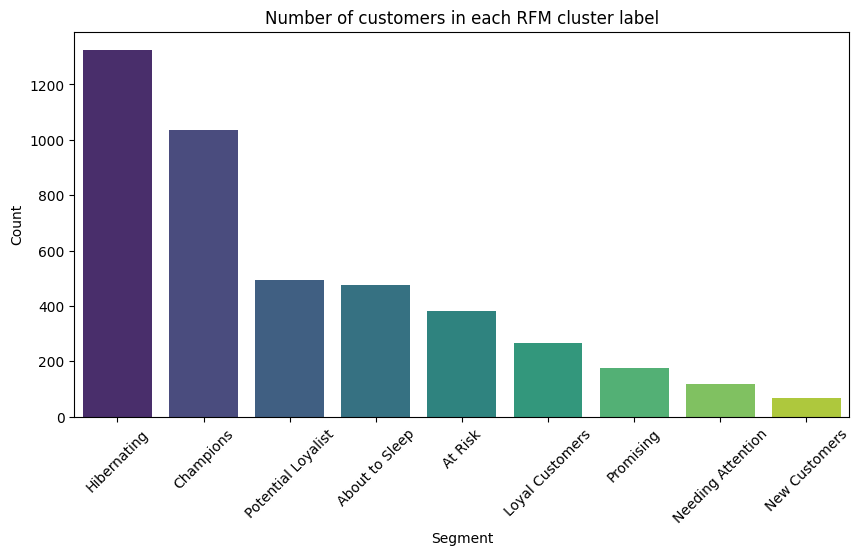

In [91]:
# Đếm số lượng khách hàng trong từng nhóm
rfm_summary = rfm['Segment'].value_counts().reset_index()
rfm_summary.columns = ['Segment', 'Count']


plt.figure(figsize=(10, 5))
sns.barplot(x='Segment', y='Count', data=rfm_summary, palette="viridis")

plt.xlabel("Segment")
plt.ylabel("Count")
plt.title("Number of customers in each RFM cluster label")

plt.xticks(rotation=45)
plt.show()

In [92]:
# Lọc nhóm khách hàng 'Promising'
promising_df = rfm[rfm['Segment'] == 'Hibernating']

# Hiển thị thống kê mô tả
print(promising_df[['CustomerID', 'Recency', 'Frequency', 'Monetary']].describe())

         CustomerID      Recency    Frequency      Monetary
count   1325.000000  1325.000000  1325.000000   1325.000000
mean   15276.597736   209.600755     1.277736    511.718945
std     1742.762203    89.697813     0.448052   2186.609558
min    12346.000000    73.000000     1.000000      3.750000
25%    13740.000000   131.000000     1.000000    168.400000
50%    15258.000000   208.000000     1.000000    310.050000
75%    16756.000000   280.000000     2.000000    540.450000
max    18281.000000   374.000000     2.000000  77183.600000


In [93]:
# Lọc nhóm khách hàng 'Promising'
promising_df = rfm[rfm['Segment'] == 'Champions']

# Hiển thị thống kê mô tả
print(promising_df[['CustomerID', 'Recency', 'Frequency', 'Monetary']].describe())

         CustomerID      Recency    Frequency       Monetary
count   1035.000000  1035.000000  1035.000000    1035.000000
mean   15200.164251    12.797101    10.690821    5612.846474
std     1724.834481     9.414452    13.399640   16600.939191
min    12347.000000     1.000000     4.000000     201.120000
25%    13755.500000     4.000000     5.000000    1421.845000
50%    15058.000000    11.000000     7.000000    2473.370000
75%    16756.000000    19.000000    12.000000    4531.605000
max    18283.000000    33.000000   210.000000  280206.020000


In [94]:
# Lọc nhóm khách hàng 'Promising'
promising_df = rfm[rfm['Segment'] == 'New Customers']

# Hiển thị thống kê mô tả
print(promising_df[['CustomerID', 'Recency', 'Frequency', 'Monetary']].describe())

         CustomerID    Recency  Frequency     Monetary
count     67.000000  67.000000       67.0    67.000000
mean   15102.328358   7.089552        1.0   348.637612
std     1804.101710   3.604422        0.0   477.750975
min    12367.000000   1.000000        1.0    41.990000
25%    13432.000000   4.000000        1.0   168.765000
50%    15148.000000   7.000000        1.0   246.300000
75%    16552.000000  11.000000        1.0   360.810000
max    18174.000000  12.000000        1.0  3861.000000


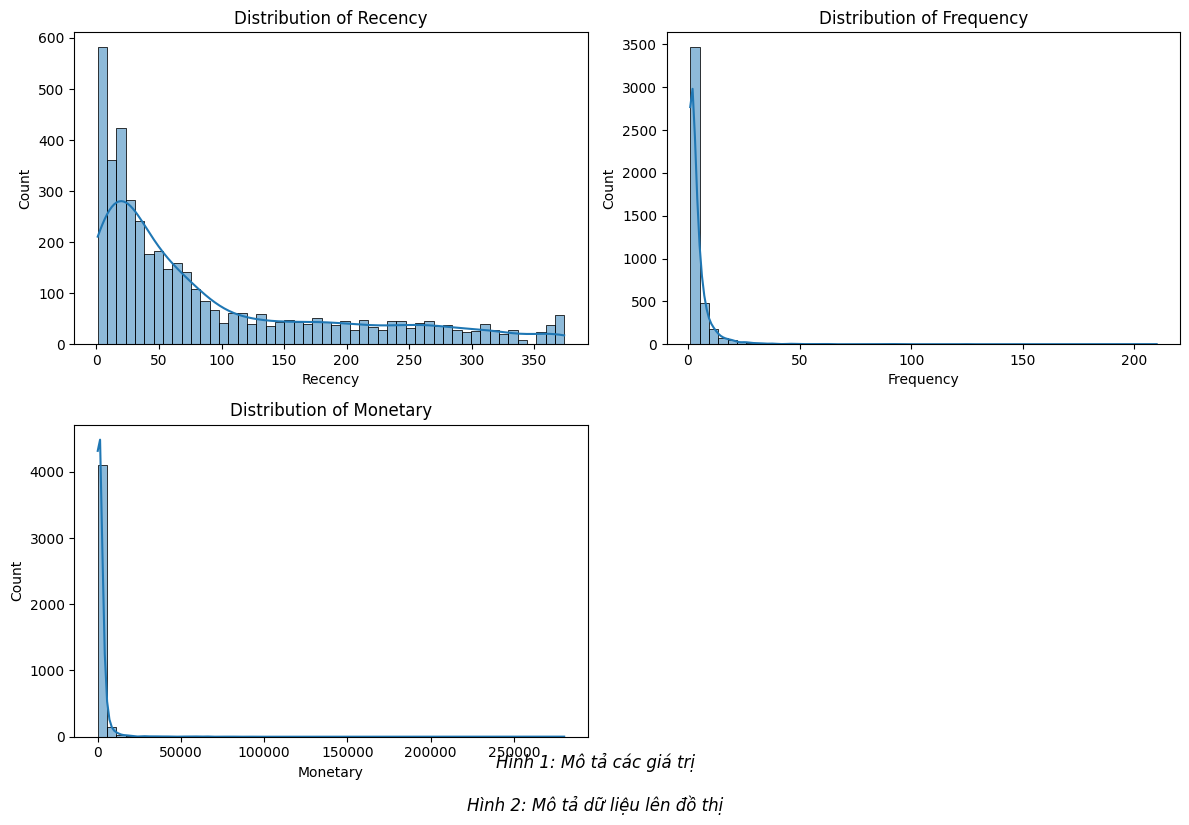

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo figure với kích thước 3 biểu đồ
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Biểu đồ phân phối của Recency
sns.histplot(rfm['Recency'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Recency")

# Biểu đồ phân phối của Frequency
sns.histplot(rfm['Frequency'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribution of Frequency")

# Biểu đồ phân phối của Monetary
sns.histplot(rfm['Monetary'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Monetary")

# Ẩn ô trống (1,1) do chỉ có 3 biểu đồ
fig.delaxes(axes[1, 1])

# Tăng khoảng cách giữa các biểu đồ
plt.tight_layout()

# Thêm chú thích bên dưới hình
plt.figtext(0.5, -0.02, "Hình 1: Mô tả các giá trị\n\nHình 2: Mô tả dữ liệu lên đồ thị", 
            ha="center", fontsize=12, style="italic")

# Hiển thị biểu đồ
plt.show()

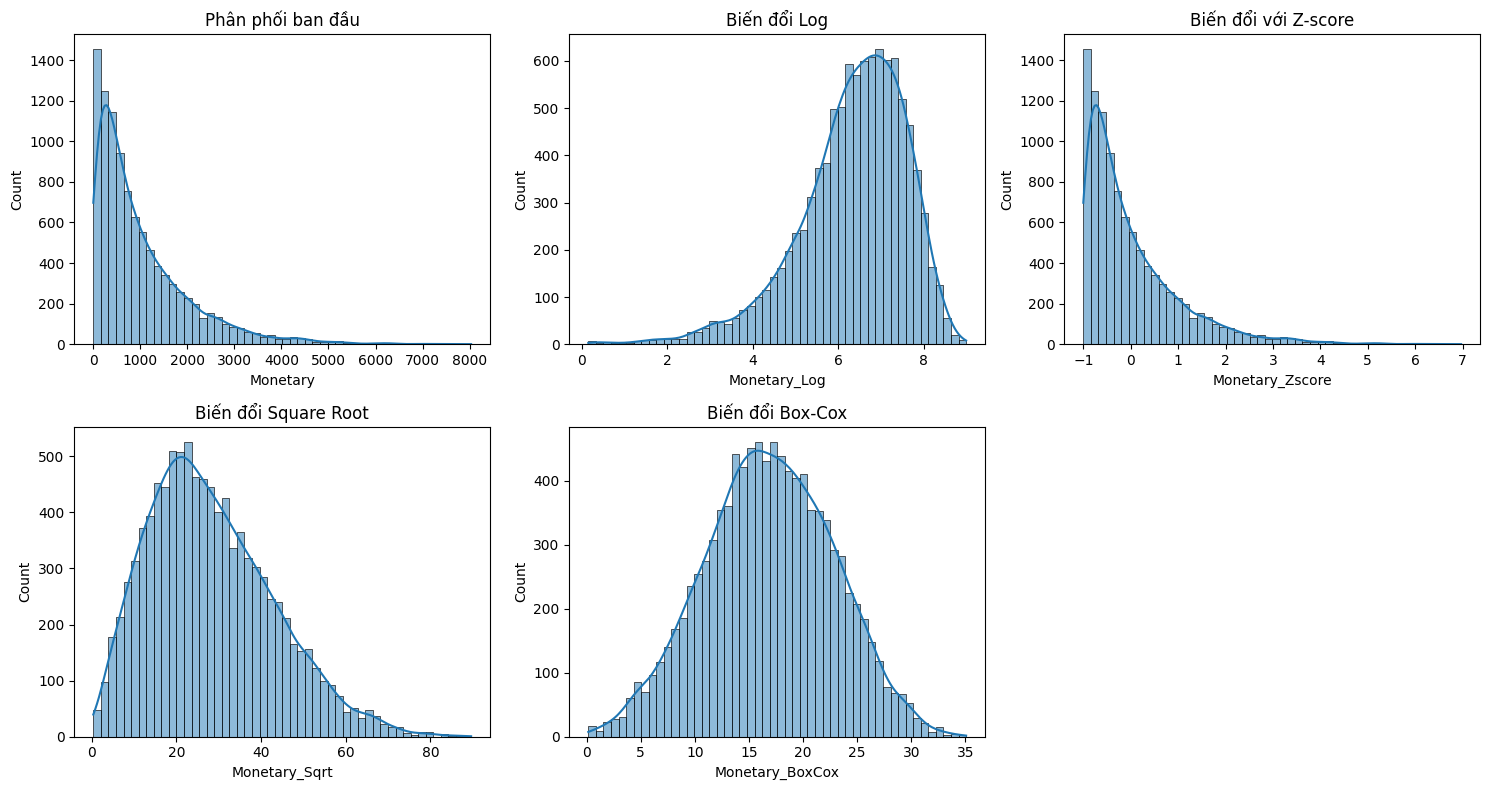

In [96]:
from scipy import stats

rfm = pd.DataFrame({'Monetary': np.random.exponential(scale=1000, size=10000)})

# Áp dụng các phương pháp biến đổi dữ liệu
rfm['Monetary_Log'] = np.log1p(rfm['Monetary'])
rfm['Monetary_Sqrt'] = np.sqrt(rfm['Monetary'])
rfm['Monetary_BoxCox'], _ = stats.boxcox(rfm['Monetary'] + 1)
rfm['Monetary_Zscore'] = (rfm['Monetary'] - rfm['Monetary'].mean()) / rfm['Monetary'].std()

# Vẽ biểu đồ phân phối
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Phân phối ban đầu
sns.histplot(rfm['Monetary'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Phân phối ban đầu")

# Biến đổi Log
sns.histplot(rfm['Monetary_Log'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Biến đổi Log")

# Biến đổi Square Root
sns.histplot(rfm['Monetary_Sqrt'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Biến đổi Square Root")

# Biến đổi Box-Cox
sns.histplot(rfm['Monetary_BoxCox'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Biến đổi Box-Cox")

# Biến đổi với Z-score
sns.histplot(rfm['Monetary_Zscore'], bins=50, kde=True, ax=axes[0, 2])
axes[0, 2].set_title("Biến đổi với Z-score")

# Ẩn ô trống (1,2) do chỉ có 5 biểu đồ
fig.delaxes(axes[1, 2])

# Điều chỉnh bố cục
plt.tight_layout()
plt.show()

In [97]:

# Tính hệ số lệch (Skewness)
skew_original = round(stats.skew(rfm['Monetary']), 2)
skew_log = round(stats.skew(rfm['Monetary_Log']), 2)
skew_sqrt = round(stats.skew(rfm['Monetary_Sqrt']), 2)
skew_boxcox = round(stats.skew(rfm['Monetary_BoxCox']), 2)
skew_zscore = round(stats.skew(rfm['Monetary_Zscore']), 2)

# Hiển thị kết quả
print(f"Phân phối ban đầu: {skew_original}")
print(f"Biến đổi Log: {skew_log}")
print(f"Biến đổi Square Root: {skew_sqrt}")
print(f"Biến đổi Box-Cox: {skew_boxcox}")
print(f"Biến đổi Z-score: {skew_zscore}")

Phân phối ban đầu: 1.85
Biến đổi Log: -1.0
Biến đổi Square Root: 0.62
Biến đổi Box-Cox: -0.04
Biến đổi Z-score: 1.85


In [98]:
# Áp dụng biến đổi Square Root
df_transformed = rfm.copy()
df_transformed['Recency'] = np.sqrt(rfm['Recency'])
df_transformed['Frequency'] = np.sqrt(rfm['Frequency'])
df_transformed['Monetary'] = np.sqrt(rfm['Monetary'])

# Hiển thị dữ liệu sau khi biến đổi
print(df_transformed.head())

KeyError: 'Recency'

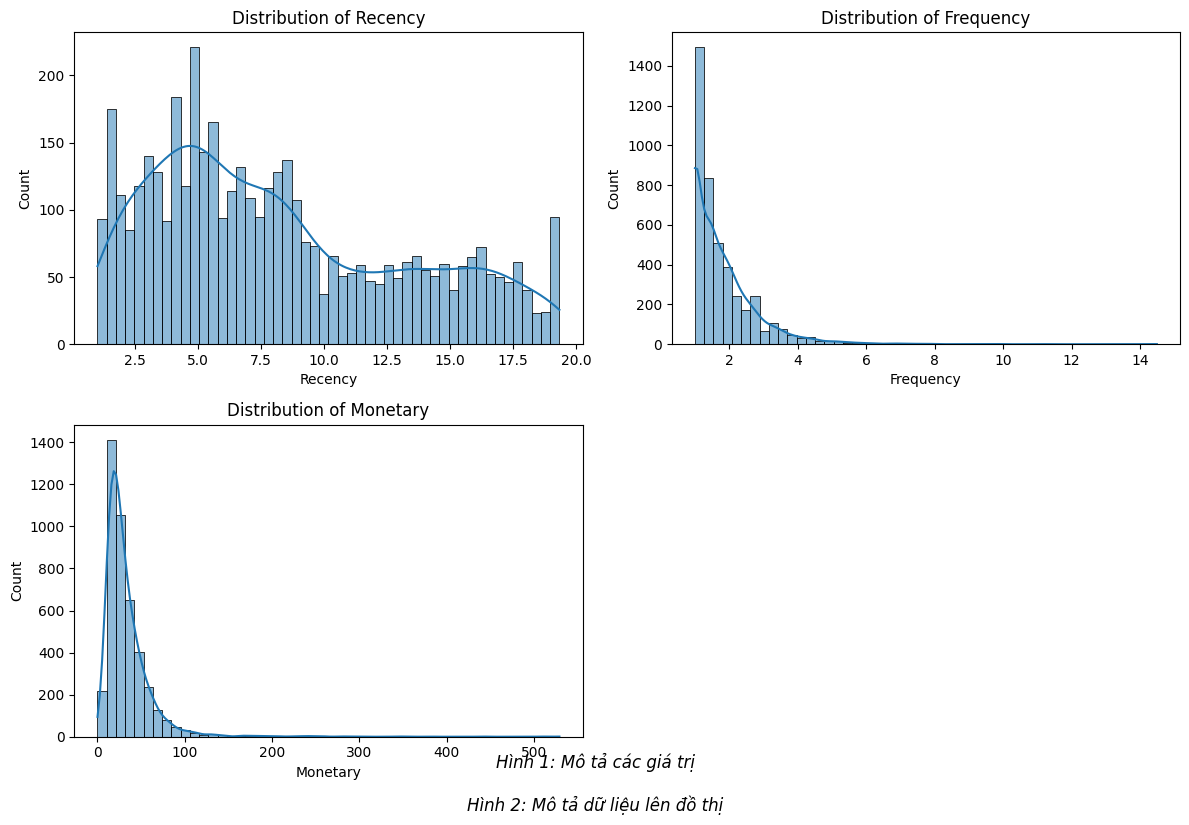

In [ ]:
# Tạo figure với kích thước 3 biểu đồ
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Biểu đồ phân phối của Recency
sns.histplot(df_transformed['Recency'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Recency")

# Biểu đồ phân phối của Frequency
sns.histplot(df_transformed['Frequency'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribution of Frequency")

# Biểu đồ phân phối của Monetary
sns.histplot(df_transformed['Monetary'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Monetary")

# Ẩn ô trống (1,1) do chỉ có 3 biểu đồ
fig.delaxes(axes[1, 1])

# Tăng khoảng cách giữa các biểu đồ
plt.tight_layout()

# Thêm chú thích bên dưới hình
plt.figtext(0.5, -0.02, "Hình 1: Mô tả các giá trị\n\nHình 2: Mô tả dữ liệu lên đồ thị", 
            ha="center", fontsize=12, style="italic")

# Hiển thị biểu đồ
plt.show()

In [ ]:
sse = []
k_range = range(1, 11)  # Số cụm từ 1 đến 10

# Chạy thuật toán K-Means cho từng số cụm k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)  # inertia_ là tổng SSE

# Vẽ biểu đồ Elbow
plt.figure(figsize=(8,5))
plt.plot(k_range, sse, marker='o', linestyle='-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method')
plt.show()

ValueError: could not convert string to float: '85123A'

In [ ]:
# Silhouette Score
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for K={k}: {score:.4f}")

# Plotting the Silhouette Scores
plt.figure(figsize=(10,6))
plt.plot(K, silhouette_scores, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Various K')
plt.xticks(K)
plt.show()

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans and compute distortion score
distortions = []
K = range(1, 11)  # Trying k from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)

# Identify the "elbow" point
elbow_k = 3  # Example, replace with dynamic elbow detection if needed
elbow_score = distortions[elbow_k - 1]

# Plot the elbow method graph
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bo-', markersize=8, label="Distortion Score")
plt.axvline(x=elbow_k, linestyle='--', color='black', label=f"Elbow at k = {elbow_k}, score = {elbow_score:.3f}")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distortion Score")
plt.title("Distortion Score Elbow for KMeans Clustering")
plt.legend()
plt.show()

In [ ]:
# Optimal number of clusters (replace with your choice based on the above analysis)
optimal_k = 4

# Initialize KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit KMeans and assign cluster labels
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Display the first few rows with cluster labels
rfm.head()


In [ ]:

# Màu sắc cho các cụm
colors = {0: 'blue', 1: 'red', 2: 'green', 3:'yellow'}
data['Color'] = data['Cluster'].map(colors)

# Vẽ biểu đồ 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Vẽ từng cụm với màu sắc tương ứng
for cluster in np.unique(data['Cluster']):
    cluster_data = data[data['Cluster'] == cluster]
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], 
               label=f"Cluster {cluster}", color=colors[cluster], alpha=0.7)

# Định dạng biểu đồ
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("Biểu đồ phân tán 3D của RFM Clustering")
ax.legend(title="Clusters")

# Hiển thị biểu đồ
plt.show()

# Đếm số lượng khách hàng trong từng cụm
cluster_counts = data['Cluster'].value_counts().sort_index()
print("Cluster Distribution:\n", cluster_counts)

In [ ]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Danh sách số lượng cụm cần kiểm tra
cluster_range = [2, 3, 4, 5]

# Vẽ biểu đồ silhouette
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, k in enumerate(cluster_range):
    # Áp dụng KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data_scaled)

    # Tính silhouette score
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    sample_silhouette_values = silhouette_samples(data_scaled, cluster_labels)

    y_lower = 10
    ax = axes[i]

    # Vẽ biểu đồ silhouette
    for j in range(k):
        cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        cluster_silhouette_values.sort()

        size_cluster_j = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        y_lower = y_upper + 10

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")  # Đường trung bình silhouette
    ax.set_title(f"Silhouette for {k} clusters")
    ax.set_xlabel("Silhouette coefficient")
    ax.set_ylabel("Cluster size")
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(data_scaled) + (k + 1) * 10])

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()